# Data Mining Process

En este notebook realizaremos todo el Data Mining Process y mostraremos los resultados:


1. Entender el problema (Problem Understanding)
2. Data Mining Process
    * Obtener los datos (Data collect)
    * Preprocesando los datos (Data Processing)
    * Exploración estadística de datos (Statistical Data Exploration)
    * Modelado (Analysis Modeling)
3. Resultados (Results)



Antes de nada, importamos las librerias y funciones necesarias:

In [30]:
import tensorflow as tf
import pandas as pd
import skmob
from skmob.measures.individual import home_location
from skmob.io.file import load_geolife_trajectories,read,write


## 2.1. Obtener los datos

Antes de crear el modelo usando Tensorflow, es necesario cargar los datos, preprocesarlos y tratarlos. Debemos realizar este proceso con el fin de tener buenos datos con los que alimentar el modelo de red neuronal que usaremos.

Para cargar los datos, usamos la función 'load_geolife_trajectories' que nos proporciona skmob. Esta función se encarga de cargar los datos de GeoLife Trajectories, solo hay que indicarle el path del directorio Data, y los usuarios que queremos cargar. Es opcional pasarle algunos parámetros de filtrado y compresión. Esta función, por cómo esta implementada, solo contempla la sintaxis de las rutas de archivos en Linux, por lo que en windows no funcionará.

Si queremos cargar/guardar estos datos, solo hay que hacer uso de las funciones read y write que proporciona skmob, que permiten escribir y cargar dataframes en formato JSON. Una vez usada la funcion 'load_geolife_trajectories', llamamos al método write para guardar el dataframe cargado en un archivo JSON. De esta forma, solo usaremos la función read() para cargar este dataframe previamente guardado.

In [31]:
# Los datos ya están en el fichero, por lo que
# no hace falta cargarlos salvo que queramos introducir nuevos

# path = "/home/alonso/Documentos/tfg/Geolife_Trajectories/"
# traj_df = load_geolife_trajectories(path, user_ids=[120,121,122,123,124],
#                                  compress_kwargs={'spatial_radius_km': 0.0})
# write (traj_df, json_path)

In [32]:
json_path= "../../Data/gps_data.json"
traj_df = read(json_path)


## 2.2. Preprocesando los datos

En esta segunda fase, es importante tener una "visión global" de los datos, con el fin de entenderlos mejor. Una buena idea es ver si hay datos nulos en la información que tenemos, ya que estos deberían ser tratados. Se puede ver que en esta ocasión, no los hay. Si los hubiese, una opción podría ser la de descartar estos datos. Para realizar esto último, se podría hacer uso del método dropna() para descartar las filas con algún dato nulo los datos. Otra opcion sería remplazar los nulos por algun otro valor con fillna(), como la mediana o algún otro que deseemos.

In [33]:
df = pd.DataFrame(traj_df)
print('Total de valores nulos de cada columna: ')
print(df.isna().sum() )

Total de valores nulos de cada columna: 
lat         0
lng         0
datetime    0
uid         0
dtype: int64


In [34]:
print('\nVistazo de los datos:')
df[0:10]


Vistazo de los datos:


,lat,lng,datetime,uid
0,39.982375,116.320442,2009-09-19 07:11:37,120
1,39.982380,116.320448,2009-09-19 07:11:48,120
2,39.982380,116.320455,2009-09-19 07:11:50,120
3,39.982397,116.320455,2009-09-19 07:11:52,120
4,39.982425,116.320460,2009-09-19 07:11:54,120
5,39.982458,116.320463,2009-09-19 07:11:56,120
6,39.982503,116.320447,2009-09-19 07:11:58,120
7,39.982510,116.320418,2009-09-19 07:12:00,120
8,39.982525,116.320375,2009-09-19 07:12:02,120
9,39.982547,116.320342,2009-09-19 07:12:04,120


Es hora de obtener nuestra columna objetivo (la que intentaremos predecir) que no es otra que la columna 'at_home' que indica si el individuo está en casa o no. 

Para obtener la localización de las casas de cada individuo en el dataset, scikit-mobility nos proporciona la función home_location(). Esta función observa la localización más frecuentada en la noche (Entre las 22:00 y las 07:00) por los usuarios y designa a este como su casa. Estas horas son modificables, aunque no lo haremos ya que lo normal, es estar en casa entre esas horas. 

Una vez obtenidas las posiciones de la casa, se compararán con las diferentes posiciones de cada invidividuo para saber si esta en casa o no. Debido a la precisión milimétrica de los datos GPS, la localización de la casa tambien resultará milimétrica. Esto llevará a que habra pocas coincidencias entre la posición de la casa y la posición del individuo, por lo que obtendremos pocas observaciones que indiquen que el individuo está en casa. Por esto, y pese a que se pierda precisión, se redondearán los datos del GPS. De esta forma, aunque se pierda precisión, sabremos que el individuo está cerca de su casa y obtendremos más datos positivos.

In [35]:
df=df.round({'lat': 3, 'lng': 3})
home_loc_df = home_location(df)
home_loc_df.head()


100%|██████████| 5/5 [00:00<00:00, 133.25it/s]


,uid,lat,lng
0,120,42.405,117.249
1,121,39.153,117.180
2,122,39.968,116.400
3,123,34.270,108.932
4,124,36.619,101.812


Como ya tenemos los dos dataframes, uno con los datos GPS y otro con las localizaciones de las casas de cada individuo, es necesario trabajar con ellos para obtener la columna 'at_home' explicada antes. Los pasos a realizar serían los siguientes:

* Añadimos al dataframe de los datos GPS (nuestro 'df') una columna extra que indicará si esta en casa y la inicializamos con 0. Al dataframe con la localizacion de las casas de los individuos (home_loc_df) le añadimos una columna extra de mismo nombre, con valor 1, ya que en esa posición se encuentra la casa.

* Despues, hacemos lo que en base de datos se conoce como un JOIN LEFT usando como key los valores 'lat', 'lng' y 'uid'. Con conseguiremos tener la una columna at_home_y, con el valor de 1 cuando se encuentre una coincidencia y un valor nulo cuando no y otra at_home_x con todos sus valores 0. 

* Por último ya solo quedaría crear y asignar a una nueva columna at_home el valor de la columna at_home_y y rellenar los valores nulos con los de la columna at_home_x (que tienen valor 0). Despues ya solo quedaría descartar las columnas que sobran y quedarmos con at_home

In [36]:
df['at_home'] = 0
home_loc_df['at_home'] = 1
df = pd.merge(df, home_loc_df, on=['lat','lng','uid'], how='left')
df['at_home'] = df['at_home_y'].fillna(df['at_home_x'])  
df = df.drop(['at_home_x','at_home_y'], axis=1)
df.head()

,lat,lng,datetime,uid,at_home
0,39.982,116.32,2009-09-19 07:11:37,120,0.0
1,39.982,116.32,2009-09-19 07:11:48,120,0.0
2,39.982,116.32,2009-09-19 07:11:50,120,0.0
3,39.982,116.32,2009-09-19 07:11:52,120,0.0
4,39.982,116.32,2009-09-19 07:11:54,120,0.0


In [37]:
#Observamos el número de veces de cada valor de la columna 'at_home'
df.groupby('at_home').count()

,lat,lng,datetime,uid
at_home,,,,
0.0,198000,198000,198000,198000
1.0,11482,11482,11482,11482


Obtenida la columna objetivo, es necesario tratar el resto del dataframe. Empezaremos con la columa 'datetime'. El fin de esto, es pasar de un formato de fecha (malo para una red neuronal) a un formato numérico. Para esto nos ayudaremos de numpy

In [38]:
import numpy as np
df['datetime_int'] = df.datetime.values.astype(np.int64) // 10**9
df = df.drop('datetime', axis = 1)
df = df[['uid', 'lat', 'lng', 'datetime_int', 'at_home']]
df.head()

,uid,lat,lng,datetime_int,at_home
0,120,39.982,116.32,1253344297,0.0
1,120,39.982,116.32,1253344308,0.0
2,120,39.982,116.32,1253344310,0.0
3,120,39.982,116.32,1253344312,0.0
4,120,39.982,116.32,1253344314,0.0


## 2.3. Exploración estadística de datos

Observaremos las estadísticas de los datos y  comprobaremos si hay correlaciones entre ellos

In [39]:
print(df.dtypes)

uid               int64
lat             float64
lng             float64
datetime_int      int64
at_home         float64
dtype: object


In [40]:
df.describe()

,uid,lat,lng,datetime_int,at_home
count,209482.000000,209482.000000,209482.000000,2.094820e+05,209482.000000
mean,123.026957,36.376787,104.848548,1.234951e+09,0.054811
std,1.199949,4.239933,11.316543,1.379481e+07,0.227612
min,120.000000,22.535000,90.534000,1.222807e+09,0.000000
25%,122.000000,33.767000,92.665000,1.222923e+09,0.000000
50%,124.000000,36.971000,108.727000,1.223032e+09,0.000000
75%,124.000000,39.974000,116.399000,1.251898e+09,0.000000
max,124.000000,42.551000,117.958000,1.255298e+09,1.000000


In [41]:
correlation_matrix =  df.corr()
correlation_matrix['at_home'].sort_values(ascending=False)

at_home         1.000000
lng             0.222366
datetime_int    0.177576
lat             0.163795
uid            -0.182709
Name: at_home, dtype: float64

Hemos observado que no hay correlaciones, aunque tambien nos hemos dado cuenta de que los valores que maneja el dataframe no son los más adecuados para alimentar un modelo de red neuronal.

## 2.4. Modelado

Antes de crear el modelo de red neuronal con Tensorflow, es necesario normalizar las columnas ya que los valores de estas, no son adecuados para una red neuronal. Esto se hace para impedir que alguna feature influya más que otra en la predicción. Además, el hecho de tener los datos en valores entre 0 y 1, facilita bastante el entrenamiento. Para esto nos ayudaremos de sklearn y su método MinMaxScaler. Mostando el dataframe nos damos cuenta que los datos se han normalizado correctamente.

In [42]:
from sklearn.preprocessing import MinMaxScaler
df_preprocesed = df.copy()
scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(df_preprocesed) 
df_preprocesed.loc[:,:] = scaled_values
df_preprocesed.describe()


,uid,lat,lng,datetime_int,at_home
count,209482.000000,209482.000000,209482.000000,209482.000000,209482.000000
mean,0.756739,0.691536,0.521972,0.373778,0.054811
std,0.299987,0.211827,0.412651,0.424566,0.227612
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.561151,0.077706,0.003575,0.000000
50%,1.000000,0.721223,0.663397,0.006933,0.000000
75%,1.000000,0.871253,0.943152,0.895354,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


Ahora debemos dividirlos en el set de entrenamiento y en el set de test, manteniendo la misma proporción de valores de la columna 'at_home' en ambos sets.

Para esto nos podemos ayudar de sklearn y su método StratifiedShuffleSplit. Para verificar que los datos se han separado en la misma proporción, basta con dividir tanto el número de 0 como de 1 entre el total de datos de cada set respectivamente.

In [43]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in split.split(df_preprocesed, df_preprocesed["at_home"]):
    strat_train_set = df_preprocesed.loc[train_index]
    strat_test_set = df_preprocesed.loc[test_index]   
    

In [44]:
strat_test_set["at_home"].value_counts() / len(strat_test_set)

0.0    0.94518
1.0    0.05482
Name: at_home, dtype: float64

In [45]:
strat_train_set["at_home"].value_counts() / len(strat_train_set)

0.0    0.945192
1.0    0.054808
Name: at_home, dtype: float64


Dividido el dataframe en entrenamiento y test, ahora debemos separar la columna 'at_home' del resto de features en ambos conjuntos, ya que es la columna a predecir (nuestro target). Para ello usaremos pandas.

In [46]:
x_columns = df_preprocesed.columns.drop('at_home')
x_train= strat_train_set[x_columns].values
y_train= strat_train_set['at_home'].values
x_test= strat_test_set[x_columns].values
y_test= strat_test_set['at_home'].values

Ahora crearemos el modelo de Tensorflow 2.0 usando la API de alto nivel que incorpora llamada keras:

* La input layer no es una capa en sí, si no de celulas encargadas de recibir un tensor, concretamente el tensor que se manda a la primera capa oculta. 
* El tensor debe tener la misma shape(forma) que nuestros datos. En nuestro caso, este tensor es de 1D (un vector), con un tamaño igual al número de features de nuestro set de nuestro set de entrenamiento 'train_set'

* Se utilizarán dos hidden layer (hidden layer 1 y hidden layer 2) con 10 neuronas cada una, utilizando la función de activación 'relu'
* En cuanto a la ouput layer o capa de salida, estará compuesta de 1 neurona, ya que solo queremos predecir un dato. Como estamos haciendo una clasificación binaria, deberemos usar la función de activación 'sigmoid' que dará valores entre 0 y 1, lo que nos viene perfecto. 
* La función de perdida será la 'binary_crossentropy', que es la usada en problemas de clasificación binaria.






<img src="../../Images/neural_net.png" style = "display: block;max-height:400px;width: auto;height:auto;margin-left:auto; margin-right:auto;" >

In [47]:
from tensorflow import keras
from tensorflow.keras import layers

def build_model():
  model = keras.Sequential([
    layers.Dense(10, activation = 'relu', input_dim=x_train.shape[1],
                 kernel_initializer='random_normal'),
    layers.Dense(10, activation = 'relu',
                 kernel_initializer='random_normal'),
      
    layers.Dense(1, activation = 'sigmoid',
                 kernel_initializer='random_normal')
  ])

  model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
    
 
  return model

model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________


Ahora entrenamos el modelo durante 5 epochs y veremos como evoluciona su precisión.

In [48]:
history = model.fit(
    x_train, 
    y_train,
    epochs=5, 
    validation_split = 0.25)

Train on 117833 samples, validate on 39278 samples
Epoch 1/5
117833/117833 [==============================] - 14s 115us/sample - loss: 0.2092 - accuracy: 0.9449 - val_loss: 0.1733 - val_accuracy: 0.9459
Epoch 2/5
117833/117833 [==============================] - 12s 102us/sample - loss: 0.1564 - accuracy: 0.9450 - val_loss: 0.1374 - val_accuracy: 0.9459
Epoch 3/5
117833/117833 [==============================] - 12s 103us/sample - loss: 0.1378 - accuracy: 0.9450 - val_loss: 0.1324 - val_accuracy: 0.9459
Epoch 4/5
117833/117833 [==============================] - 12s 102us/sample - loss: 0.1354 - accuracy: 0.9450 - val_loss: 0.1317 - val_accuracy: 0.9459
Epoch 5/5
117833/117833 [==============================] - 12s 101us/sample - loss: 0.1347 - accuracy: 0.9450 - val_loss: 0.1314 - val_accuracy: 0.9459


In [49]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist[0:5]

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.209173,0.944897,0.173305,0.945873,0
1,0.156429,0.944964,0.137379,0.945873,1
2,0.137807,0.944964,0.132425,0.945873,2
3,0.135369,0.944964,0.131746,0.945873,3
4,0.134738,0.944964,0.131437,0.945873,4


## 3. Resultados

Vemos que el modelo ha partido un 88% de precisión en el primer epoch, y hemos conseguido subir poco a poco hasta un 90%, lo que no está nada mal. Ahora, probamos el modelo con el test de prueba para ver que resultados obtenemos. Los resultados estarán en un array pred y estos serán números entre 0 y 1 (por la función de acitivación 'sigmoid' en la neurona de salida), por lo que es necesario redondearlos para poder compararlos luego con el array 'y_test'.

In [50]:
pred = model.predict(x_test)

pred= np.concatenate(pred)

max_value = pred.max()
umbral = max_value/2

pred_round = np.where(pred > umbral, 1, 0)
print(pred_round)


[0 0 0 ... 1 1 1]


In [51]:
y_test

array([0., 0., 0., ..., 0., 1., 0.])

Visualizando ambos array uno al lado del otro, tanto el de predicciones como el que tiene los verdaderos valores, vemos que estos coinciden, pero veamos que precisión tiene el modelo si se prueba contra el set de prueba.

In [52]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

52371/52371 - 2s - loss: 0.1338 - accuracy: 0.9452

Test accuracy: 0.9451796


Para obtener una mejor visualización de los resultados, para un problema de clasificación binaria, es bastante util usar tanto la matriz de confusión, como la la curva ROC. Las funciones de aquí abajo nos ayudan a dibujarlas.

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#Dibujar la matriz de confusion.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')    

#Dibujar la curva ROC. pred:las predicciones, y: los datos reales.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

La matriz de confusión es una herramienta muy ùtil (sobretodo en aprendizaje supervisado) para ver el rendimiento de un modelo de clasificación binaria. Cada columna de la matriz representa la cantidad predicha de cada clase, y cada fila representa la cantidad real de cadae la clase real.

Si en los datos de entrada hay mucho desbalance en las clases esto puede crear problemas a la hora de predecir. Si por ejemplo hay 90 muestras de la clase 1 y sólo 10 de la clase 2, el clasificador puede tener fácilmente un sesgo hacia la clase 1, ya que si el clasificador las clasifica todas como clase 1, habrá acertado el 90%, pero habrá tenido un 100% de error en la clasificación de la clase 2.

En nuestro caso obtenemos alrededor de un 90% de acierto para la clase 0 y alrededor de un 85% de acierto para la clase 1, lo que no esta nada mal teniendo en cuenta el gran desbalance que hay en la información.

In [54]:
y_actu = pd.Series(y_test, name='Actual')
y_pred_bool = pd.Series(pred_round, name='Predicted')
print(pd.crosstab(y_actu, y_pred_bool))

Predicted      0     1
Actual                
0.0        44765  4735
1.0          594  2277


Normalized confusion matrix
[[0.90434343 0.09565657]
 [0.20689655 0.79310345]]


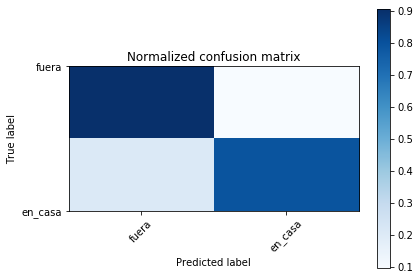

In [55]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred_round)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, ['fuera','en_casa'], title='Normalized confusion matrix')

plt.show()

La curva ROC tiene que ver con los conceptos estadísticos de sensibilidad y especificidad. Si la curva estuviese cerca de la pendiente (50%) nuestro modelo predeciría lo mismo que lanzar una moneda al aire. Si la curva estuviese por debajo de esta, el modelo cometería más fallos que aciertos, es decir, clasificaría más veces a la clase a como b o a la clase b como a. Por lo tanto, interesa que la curva se acerce a la parte superior izquierda.

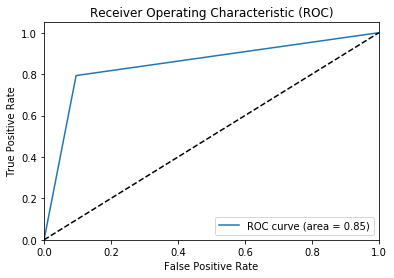

In [56]:
plot_roc(pred_round,y_test)